In [9]:
from deepxde.nn.pytorch.deeponet import DeepONet
from neuralop.models import FNO1d 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

r = 64
model = FNO1d(
    hidden_channels=64,
    n_modes_height=32,
    in_channels=4,
    out_channels=1,
).to(device)

# initialize weights
def init_fn(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

model.apply(init_fn)

optimizer = optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

progress_bar = tqdm(range(500))


# 2. data generator that yields batches of (q,p,m,l)
def sample_batch(batch_size, q_range, p_range, m_range, l_range):
    # sample parameters
    m_batch = torch.empty(batch_size,1).uniform_( *m_range )
    l_batch = torch.empty(batch_size,1).uniform_( *l_range )
    # sample points
    q_batch = torch.empty(batch_size,1).uniform_( *q_range )
    p_batch = torch.empty(batch_size,1).uniform_( *p_range )
    # send to device
    for t in (m_batch, l_batch, q_batch, p_batch):
        t.to(device)
    # require gradients for branch inputs
    q_batch.requires_grad_(True)
    p_batch.requires_grad_(True)
    return m_batch, l_batch, q_batch, p_batch

def closure():
    optimizer.zero_grad()

    m_b, l_b, q_b, p_b = sample_batch(
        batch_size=4096,
        q_range=(-torch.pi/2,torch.pi/2),
        p_range=(-2,2),
        m_range=(0.5,4.0),
        l_range=(0.5,4.0),
    )
    omega_b = torch.sqrt(9.81 / l_b)  # omega = sqrt(g/l)

    # stack branch and trunk inputs
    branch_in = torch.cat((q_b, p_b), dim=1)       # [B,2]
    trunk_in  = torch.cat((m_b, l_b), dim=1)       # [B,2]

    total_in = torch.cat((branch_in, trunk_in), dim=1).unsqueeze(-1)  # [B,4]

    H = model(total_in).squeeze(-1)               # [B,1]

    grad_outputs = torch.ones_like(H)
    dH_dq, dH_dp = torch.autograd.grad(
        outputs=H,
        inputs=(q_b, p_b),
        grad_outputs=(grad_outputs, grad_outputs),
        create_graph=True
    )

    # physics losses
    loss_mom   = torch.mean((dH_dp - (p_b/(m_b*l_b**2)))**2)
    loss_torque = torch.mean((dH_dq - (m_b*(l_b**2)*(omega_b**2)*torch.sin(q_b)))**2)
    
    dqdt = dH_dp
    dpdt = -dH_dq
    dH_dt = dH_dq * dqdt + dH_dp * dpdt
    loss_cons  = torch.mean(dH_dt**2)

    
    # Enforce Hamiltonian is the same at all test points
    loss = loss_mom + loss_torque + loss_cons
    
    if torch.isnan(loss) or torch.isinf(loss):
        print("Loss is NaN or Inf, skipping backward pass.")
        return torch.tensor(loss_track[-1]) if loss_track else 0.0
    
    
    loss.backward()
    return loss

loss_track = []

# training loop
for epoch in progress_bar:
    optimizer.step(closure)
    current = closure().item()
    loss_track.append(current)
    progress_bar.set_postfix(Loss=current)


 94%|█████████▍| 470/500 [02:13<00:07,  3.84it/s, Loss=0.329]

Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.


 94%|█████████▍| 471/500 [02:13<00:10,  2.69it/s, Loss=0.254]

Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.
Loss is NaN or Inf, skipping backward pass.


100%|██████████| 500/500 [02:21<00:00,  3.53it/s, Loss=0.24] 


In [13]:
torch.save(model.state_dict(), "hfno_pendulum.pth")

In [14]:
# Generator function for creating uniformly sampled data in the (q, p) space from (q_min, q_max) and (p_min, p_max), convert to meshgrid
def generate_uniform_data(q_min, q_max, p_min, p_max, num_samples):
    q_lin = torch.linspace(q_min, q_max, num_samples)
    p_lin = torch.linspace(p_min, p_max, num_samples)
    P, Q = torch.meshgrid(p_lin, q_lin, indexing='ij')
    P = P.reshape(-1,1).to(device).requires_grad_(True)
    Q = Q.reshape(-1,1).to(device).requires_grad_(True)
    return P, Q

In [23]:
m_test, l_test = 3, 3
p_test, q_test = generate_uniform_data(-torch.pi/2, torch.pi/2, -2, 2, 50)
p_test.requires_grad_(True)
q_test.requires_grad_(True)

# pack branch (q,p) and trunk (m,l)
branch = torch.cat((q_test, p_test), dim=1)  # [2500,2]
trunk  = torch.tensor([[m_test, l_test]], device=device).repeat(branch.size(0), 1)
total_in = torch.cat((branch, trunk), dim=1).unsqueeze(-1)  # [2500,4]

# forward and gradients
H_pred = model(total_in).squeeze(-1)             # [2500,1]
ones   = torch.ones_like(H_pred)
dH_dq, dH_dp = torch.autograd.grad(
    outputs=H_pred,
    inputs=(q_test, p_test),
    grad_outputs=(ones, ones),
    create_graph=False
)

omega_test = torch.sqrt(torch.ones_like(p_test) * 9.81 / l_test)  # omega = sqrt(g/l)

# compute residuals
mom_mse   = torch.mean((dH_dp - (p_test/(m_test*l_test**2)))**2).item()
force_mse = torch.mean((dH_dq - (m_test*(l_test**2)*(omega_test**2)*torch.sin(q_test)))**2).item()


print(f"momentum MSE: {mom_mse:.3e}")
print(f"force    MSE: {force_mse:.3e}")


momentum MSE: 1.216e-02
force    MSE: 5.085e-02


In [24]:
def derivatives_test(state):
    q_val, p_val = state
    # require grad for branch inputs
    q_t = torch.tensor([[q_val]], dtype=torch.float32, requires_grad=True, device=device)
    p_t = torch.tensor([[p_val]], dtype=torch.float32, requires_grad=True, device=device)

    # pack inputs and predict
    inp_branch = torch.cat((q_t, p_t), dim=1)
    inp_trunk  = torch.tensor([[m_test, l_test]], device=device)
    inp_total = torch.cat((inp_branch, inp_trunk), dim=1).unsqueeze(-1)  # [1,4]
    H_t = model(inp_total).squeeze(-1)  # [1]

    dH_dq_t, dH_dp_t = torch.autograd.grad(
        outputs=H_t,
        inputs=(q_t, p_t),
        grad_outputs=torch.ones_like(H_t),
        create_graph=False
    )

    dqdt = dH_dp_t.item()
    dpdt = -dH_dq_t.item()  # no damping here
    return np.array([dqdt, dpdt])


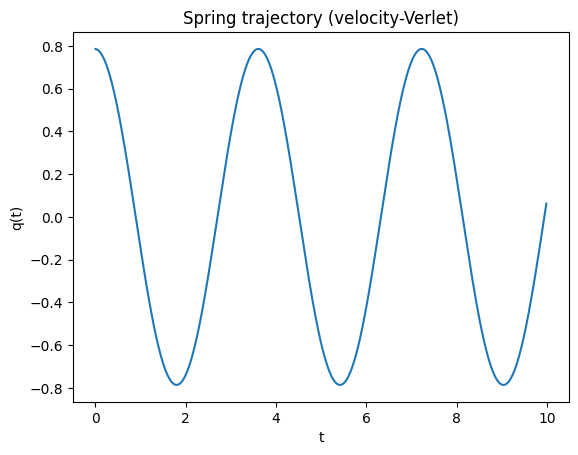

In [25]:
t0, tf, dt = 0.0, 10.0, 0.01
time = np.arange(t0, tf, dt)
trajectory = np.zeros((len(time), 2))

trajectory = np.zeros((len(time), 2))
trajectory[0] = [torch.pi/4, 0.0]

# get initial derivatives
dqdt, dpdt = derivatives_test(trajectory[0])   # dqdt = v, dpdt = m·a

for i in range(1, len(time)):
    q_n, p_n = trajectory[i-1]
    v_n = dqdt
    a_n = dpdt / (m_test * l_test**2)

    q_new = q_n + v_n*dt + 0.5*a_n*dt**2

    dqdt_new, dpdt_new = derivatives_test([q_new, p_n])
    a_new = dpdt_new / (m_test * l_test**2)

    v_new = v_n + 0.5*(a_n + a_new)*dt
    p_new = v_new / (m_test * l_test**2)

    trajectory[i] = [q_new, p_new]
    dqdt, dpdt = v_new, dpdt_new

# ----- plot q(t) -----
plt.figure()
plt.plot(time, trajectory[:, 0])
plt.xlabel('t')
plt.ylabel('q(t)')
plt.title('Spring trajectory (velocity-Verlet)')
plt.show()


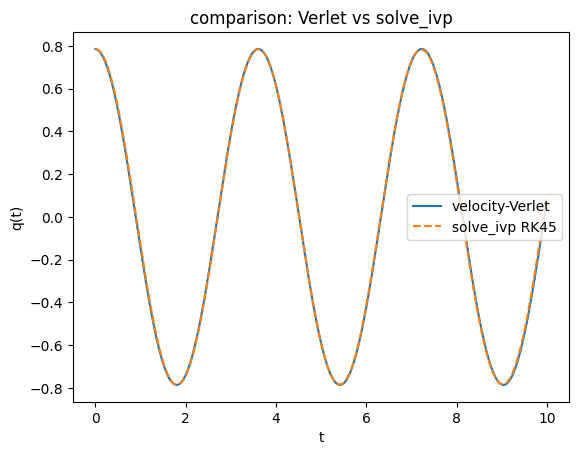

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# time grid
t0, tf, dt = 0.0, 10.0, 0.01
time = np.arange(t0, tf, dt)

# initial state
q0 = np.pi/4
p0 = 0.0

# define the pendulum ODE
def pendulum(t, state):
    q, p = state
    dqdt = p/(m_test*l_test**2)
    dpdt = -m_test*9.81*l_test*np.sin(q)
    return [dqdt, dpdt]

# integrate with a Runge-Kutta method
sol = solve_ivp(
    pendulum,
    (t0, tf),
    [q0, p0],
    t_eval=time,
    method='RK45'
)

q_ref = sol.y[0]  # reference q(t)

# now plot
plt.figure()
plt.plot(time, trajectory[:,0], label='velocity-Verlet')
plt.plot(time, q_ref, '--', label='solve_ivp RK45')
plt.xlabel('t')
plt.ylabel('q(t)')
plt.title('comparison: Verlet vs solve_ivp')
plt.legend()
plt.show()
